COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [10]:
# install dependencies
!rm -r Neural_Networks-101-demo
!git clone -b explanations https://github.com/KiranArun/Neural_Networks-101-demo.git
!python3 /content/Neural_Networks-101-demo/scripts/setup.py helper_funcs pytorch

Cloning into 'Neural_Networks-101-demo'...
remote: Counting objects: 352, done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 352 (delta 30), reused 57 (delta 14), pack-reused 271
Receiving objects: 100% (352/352), 7.53 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Installing Pytorch...
Getting helper functions...


# MNIST Handwriten Digits Classifier

In [0]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as utils

import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor
import helper_funcs as helper

In [12]:
# this is the directory where we will keep and external files, eg. data, logs
model_root_dir = '/content/'

# get data
mnist = helper.MNIST_data(model_root_dir+'MNIST_data/')

Download complete.
Save complete.


In [0]:
# Hyperparams
image_dims = (28,28)
input_size = 28**2
num_classes = 10

batch_size = 100
learning_rate = 0.2

epochs = 2

hidden_size = 256

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    long_dtype = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor
    long_dtype = torch.LongTensor

In [0]:
# create pytorch dataset with mnist data
training_dataset = utils.TensorDataset(torch.Tensor(mnist.train_images),torch.LongTensor(np.argmax(mnist.train_labels,axis=1)))

# create pytorch dataloader for extra features and ease of use in training loop
training_loader = utils.DataLoader(dataset=training_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

In [0]:
# define NN
class Net(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        
        # define hidden layer
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        
        # define output layer
        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    # define forward pass function    
    def forward(self, x):
        
        # apply hidden layer
        x = F.relu(self.hidden_layer(x))
        
        out = self.output_layer(x)
        
        return out

In [0]:
# set net to our Net with params
net = Net(input_size, num_classes)

# define loss function
loss_func = nn.CrossEntropyLoss() 
# define optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) 

if torch.cuda.is_available():
    net.cuda()
    loss_func.cuda()

In [0]:
# create function to calculate accuracy
def get_accuracy(images,labels):
    
    test_x = Variable(torch.Tensor(images)).type(dtype)
    test_y = torch.LongTensor(labels).type(long_dtype)

    _outputs = net(test_x)
    _, _predicted = torch.max(_outputs.data, 1)
    
    num_correct = (_predicted == test_y).sum()
    num_total = test_y.size(0)

    return(str(100.0 * num_correct/num_total)+'%')

In [19]:
# calculate iterations to print as total steps
iterations = int(ceil(training_loader.dataset.target_tensor.size()[0]/float(batch_size)))

# initialize losses array
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    
    # for each batch in data loader
    for iteration, (images, labels) in enumerate(training_loader):
        
        # set images and labels to variables so we can calculate the gradient
        images = Variable(images.view(-1, input_size)).type(dtype)
        labels = Variable(labels).type(long_dtype)

        # reset the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        # calculate loss
        loss = loss_func(outputs, labels)
        # calculate parameter gradients
        loss.backward()
        # update weights
        optimizer.step()

        if (iteration+1) % floor(iterations/5) == 0:
            # calculate validation accuracy
            _accuracy = get_accuracy(mnist.validation_images, np.argmax(mnist.validation_labels,axis=1))
            # print current status
            print('step', str(iteration+1)+'/'+str(iterations), 'loss', loss.data[0], 'accuracy', _accuracy)
            
        # append current loss to losses array to plot
        losses = np.append(losses, loss.data[0])

New epoch 1/2
step 110/550 loss 0.40054023265838623 accuracy 91.14%
step 220/550 loss 0.30789461731910706 accuracy 91.54%
step 330/550 loss 0.3573753237724304 accuracy 93.3%
step 440/550 loss 0.2660757005214691 accuracy 94.2%
step 550/550 loss 0.3652195334434509 accuracy 94.7%
New epoch 2/2
step 110/550 loss 0.14829793572425842 accuracy 95.32%
step 220/550 loss 0.11169912666082382 accuracy 95.58%
step 330/550 loss 0.32452964782714844 accuracy 95.42%
step 440/550 loss 0.1859707087278366 accuracy 96.54%
step 550/550 loss 0.17038770020008087 accuracy 96.44%


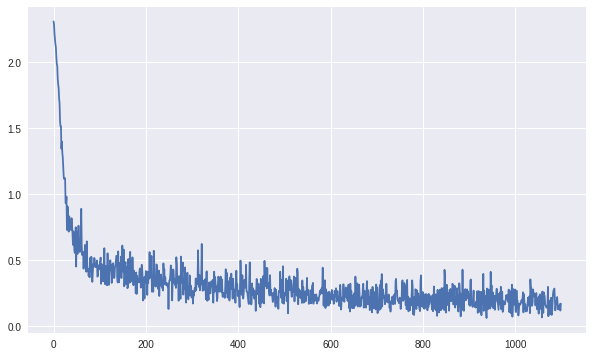

In [20]:
# plot losses
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

In [21]:
# show evaluation accuracy
print(get_accuracy(mnist.test_images,np.argmax(mnist.test_labels,axis=1)))

95.21%


prediction: 1 answer: 7
0 0.06%
1 81.91%
2 3.74%
3 0.77%
4 0.47%
5 0.6%
6 0.16%
7 3.39%
8 5.95%
9 2.94%


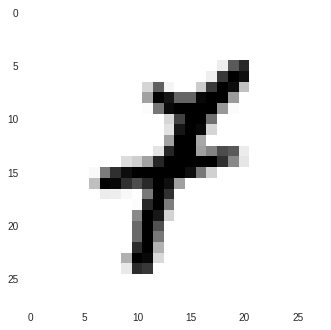

prediction: 9 answer: 9
0 0.0%
1 0.0%
2 0.0%
3 0.29%
4 0.2%
5 0.14%
6 0.0%
7 0.18%
8 0.17%
9 99.02%


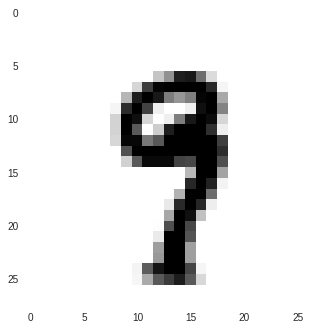

In [23]:
# test and show test images
test_idxs = [1,11]

for test_idx in test_idxs:
    test_x = Variable(torch.Tensor(mnist.test_images[test_idx].reshape(1,-1))).type(dtype)
    test_y = np.argmax(mnist.test_labels[test_idx])

    _prediction = F.softmax(net(test_x),dim=1)

    print('prediction:', np.argmax(_prediction.cpu().data.numpy()), 'answer:', test_y)

    for i,val in enumerate(_prediction[0]):
        print(i, str(round(float(100*val),2))+'%')

    plt.imshow(test_x.cpu().data.numpy().reshape(*image_dims), cmap='binary')
    plt.grid(False)
    plt.show()